# Collaborative Filtering and Group Recommendations in MovieLens 100K


**Authors**: Ashkan Khademian, Ujunwa Edum\
**Project Part**: Part I\
**Course**: DATA.ML.360-2024-2025-1 Recommender Systems

# Foundations

## Introduction

Lorem ipsum

## Install Requirements

Use the comment template for installing your packages that are not already present in the google colab environment.

In [3]:
# !pip install <package-name>

## Import Libararies

### Main Libraries

In [4]:
import typing
from time import sleep

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

### Typing

In [5]:
from typing import *
from pandas.core.frame import DataFrame, Series

## Define Constants

In [6]:
RATING_DATASET = "data/ml-latest-small/ratings.csv"

# A. Visualize Dataset

In [7]:
def visualize_rating_distribution(ratings: DataFrame) -> None:
  plt.figure(figsize=(8, 4))
  sns.histplot(ratings['rating'], bins=9, kde=True)
  plt.title('Distribution of Ratings')
  plt.xlabel('Rating')
  plt.ylabel('Count')
  plt.show()

In [8]:
def visualize_user_activity(ratings: DataFrame) -> None:
  user_activity = ratings.groupby('userId').size()
  plt.figure(figsize=(8, 4))
  sns.histplot(user_activity, bins=50, kde=True)
  plt.title('Distribution of Number of Ratings per User')
  plt.xlabel('Number of Ratings')
  plt.ylabel('Count of Users')
  plt.show()

In [9]:
def visualize_movie_popularity(ratings: DataFrame) -> None:
  movie_popularity = ratings.groupby('movieId').size()
  plt.figure(figsize=(8, 4))
  sns.histplot(movie_popularity, bins=50, kde=True)
  plt.title('Distribution of Number of Ratings per Movie')
  plt.xlabel('Number of Ratings')
  plt.ylabel('Count of Movies')
  plt.show()

In [10]:
def visualize_user_movie_matrix_heatmap(ratings: DataFrame) -> None:
  sample = ratings[(ratings['userId'].isin(range(1, 51))) & (ratings['movieId'].isin(range(1, 101)))]
  pivot_table = sample.pivot(index='userId', columns='movieId', values='rating')
  plt.figure(figsize=(8, 6))
  sns.heatmap(pivot_table, cmap='coolwarm', cbar=True, xticklabels=False, yticklabels=False,
              linewidths=0.1, linecolor='grey', mask=pivot_table.isnull(), square=True)
  plt.title('Heatmap of User-Movie Rating Matrix')
  plt.xlabel('MovieId')
  plt.ylabel('UserId')
  plt.show()

In [11]:
raw_df = pd.read_csv(RATING_DATASET)
raw_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


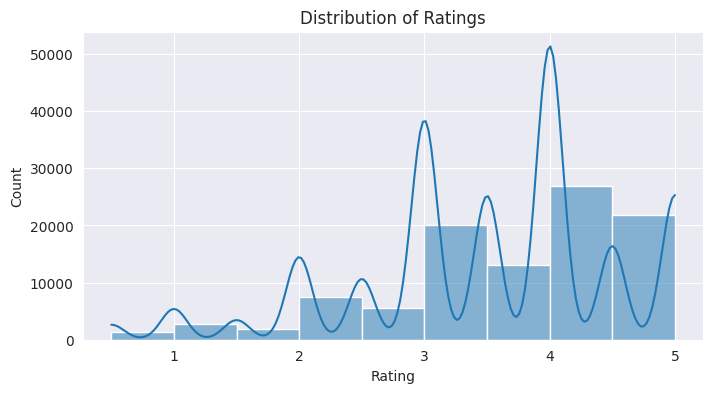

In [12]:
visualize_rating_distribution(raw_df)

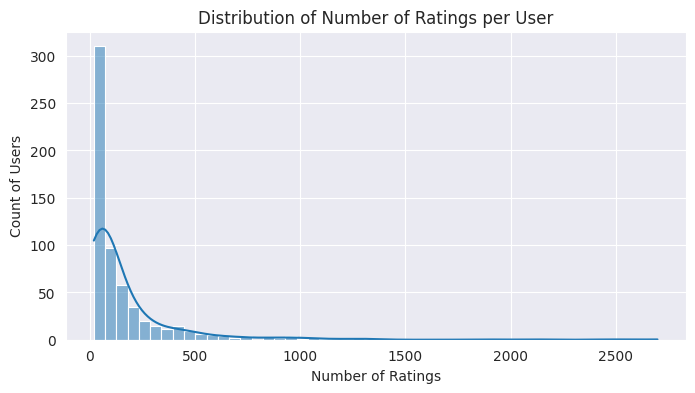

In [13]:
visualize_user_activity(raw_df)

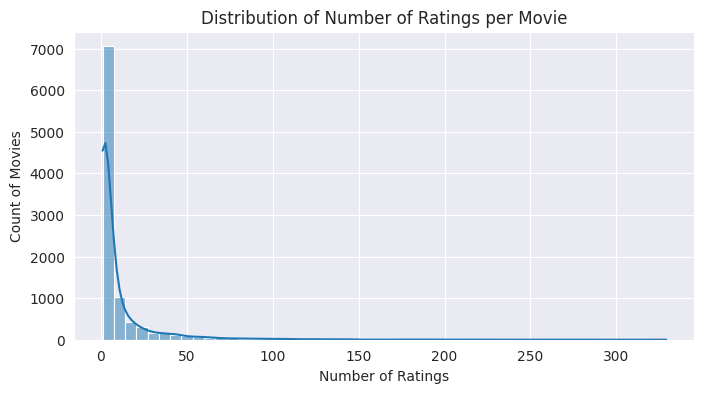

In [14]:
visualize_movie_popularity(raw_df)

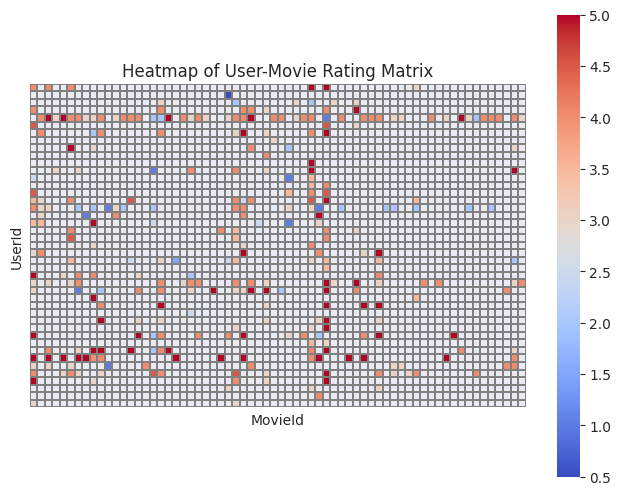

In [15]:
visualize_user_movie_matrix_heatmap(raw_df)

# B & C. User-Based Collaborative Filtering

## B. Collaborative Filtering using Pearson Similarity

In [16]:
def pearson_similarity(user1_ratings: Series, user2_ratings: Series, **kwargs) -> float:
    common_ratings = user1_ratings.dropna().index.intersection(user2_ratings.dropna().index)
    if len(common_ratings) == 0:
        return np.nan
    user1_common = user1_ratings[common_ratings]
    user2_common = user2_ratings[common_ratings]
    mean_user1 = user1_common.mean()
    mean_user2 = user2_common.mean()
    numerator = ((user1_common - mean_user1) * (user2_common - mean_user2)).sum()
    denominator = np.sqrt(((user1_common - mean_user1) ** 2).sum()) * np.sqrt(((user2_common - mean_user2) ** 2).sum())
    with np.errstate(invalid='ignore'):
        return numerator / denominator

### Transform CSV DataFrame to User-Movies Matrix
The `transform_csv_dataframe_to_user_movies_matrix` function transforms the DataFrame resulted from the dataset CSV into a user-movies matrix where the rows represent users, the columns represent movies, and the values represent the ratings given by users to movies.

In [17]:
def transform_csv_dataframe_to_user_movies_matrix(csv_df: DataFrame) -> DataFrame:
  user_movie_matrix = csv_df.pivot(index='userId', columns='movieId', values='rating')
  user_movie_matrix.reset_index(inplace=True)
  user_movie_matrix.columns.name = None
  return user_movie_matrix


### Prepare User-Movie Matrix for Collaborative Filtering
The `prepare_user_movie_matrix_for_cf_matrix` function prepares the user-movie matrix for collaborative filtering by filtering the matrix to include only the relevant users and movies. It retrieves the movies rated by the specific user and filters the user-movie matrix to include only the relevant users and movies.

In [18]:
def prepare_user_movie_matrix_for_cf_matrix(
    user_movie_matrix: DataFrame,
    movie_id: int,
    user_id: int,
  ) -> DataFrame:
    user_ratings = user_movie_matrix[user_movie_matrix['userId'] == user_id].dropna(axis=1, how='all')
    
    # Retrieve the movies rated by the specific user
    rated_movies = user_ratings.columns[1:]
    if movie_id in rated_movies:
        raise ValueError(f"The user {user_id} has already rated the movie {movie_id}")
    
    # Filter the user-movie matrix to include only the relevant users and movies
    relevant_users = user_movie_matrix[user_movie_matrix[rated_movies].notna().any(axis=1) & user_movie_matrix[movie_id].notna()]
    
    # Include the movie we want to predict if it's not already rated by the user
    rated_movies = rated_movies.append(pd.Index([movie_id]))
    
    # Return the filtered DataFrame
    relevant_users_rows = relevant_users[['userId'] + list(rated_movies)]
    user_row = user_movie_matrix[user_movie_matrix["userId"]==user_id][['userId'] + list(rated_movies)]
    return pd.concat([user_row, relevant_users_rows]).reset_index(drop=True)

### Add Similarity Column to CF Matrix
The `add_similarity_column_to_cf_matrix` function adds a new column to the collaborative filtering (CF) user-movie matrix that represents the similarity between the target user and each user in the matrix. It calculates the similarity using the provided `similarity_measure` function.

In [19]:
def add_similarity_column_to_cf_matrix(
    cf_matrix: DataFrame, movie_id: int, user_id: int,
    similarity_measure: typing.Callable[[Series, Series, Any], np.float64],
  ) -> DataFrame:
    
    target_user_ratings = cf_matrix[cf_matrix['userId'] == user_id].drop('userId', axis=1).drop(movie_id, axis=1).iloc[0]
    average_non_nan = cf_matrix[cf_matrix['userId'] != user_id].drop(['userId', movie_id], axis=1).notna().sum(axis=1).mean()
    similarities = []
    for other_user_id in cf_matrix['userId']:
        if other_user_id == user_id:
            similarities.append(1.0)  # Similarity with oneself is 1
        else:
            other_user_ratings = cf_matrix[cf_matrix['userId'] == other_user_id].drop('userId', axis=1).drop(movie_id, axis=1).iloc[0]
            similarity = similarity_measure(target_user_ratings, other_user_ratings, average_non_nan=average_non_nan)
            similarities.append(similarity)
    df_copy = cf_matrix.copy()
    df_copy['similarity'] = similarities
    return df_copy

In [20]:
def limit_neighborhood(
    cf_matrix_with_similarity: DataFrame,
    movie_id: int,
    user_id: int,
    threshold: Optional[float] = None,
) -> DataFrame:
    neighbors = cf_matrix_with_similarity.copy()
    
    if threshold is not None:
        neighbors = neighbors[neighbors['similarity'] >= threshold]

    if len(neighbors) < 3:
        raise ValueError("Number of neighbors is less than 1")

    return neighbors

## C. Predicting Scores using the Function Presented in Class

### Predict Score
The `predict_score` function calculates the predicted score for a movie by a user based on the collaborative filtering matrix with similarities. It retrieves the neighbors' ratings for the specified movie, calculates the average rating of the target user, and the average rating of each neighbor. It then calculates the weighted sum of the neighbors' ratings and the sum of the similarities to predict the score.

In [21]:
def predict_score(cf_matrix_with_similarity: DataFrame, movie_id: int, user_id: int) -> float:
    # Retrieve the neighbors' ratings for the specified movie
    neighbors_ratings = cf_matrix_with_similarity[
        cf_matrix_with_similarity['userId'] != user_id
    ][['userId', movie_id, 'similarity']].dropna()

    # Calculate the average rating of the target user
    target_user_ratings = cf_matrix_with_similarity[
        cf_matrix_with_similarity['userId'] == user_id
    ].drop(['userId', 'similarity'], axis=1).iloc[0].dropna()
    target_user_avg_rating = target_user_ratings.mean()

    # Calculate the average rating of each neighbor
    neighbors_avg_ratings = cf_matrix_with_similarity[
        cf_matrix_with_similarity['userId'].isin(neighbors_ratings['userId'])
    ].drop(['userId', 'similarity'], axis=1).mean(axis=1)

    # Calculate the weighted sum of the neighbors' ratings
    weighted_sum = sum(
        (neighbors_ratings.iloc[i][movie_id] - neighbors_avg_ratings.iloc[i]) * neighbors_ratings.iloc[i]['similarity']
        for i in range(len(neighbors_ratings))
    )

    # Calculate the sum of the similarities
    sum_of_similarities = neighbors_ratings['similarity'].sum()

    # Calculate the predicted score
    predicted_score = target_user_avg_rating + (weighted_sum / sum_of_similarities)

    return predicted_score

### Calculate Prediction using Pearson Similarity
The `calculate_prediction_using_pearson_similarity` function calculates the predicted score for a user-movie pair using the Pearson similarity. It transforms the raw DataFrame into a user-movie matrix, prepares the matrix for collaborative filtering, adds the similarity column to the matrix, limits the neighborhood based on a threshold, and predicts the score using the collaborative filtering matrix.

In [22]:
def calculate_prediction_using_pearson_similarity(
    user_id: int, 
    movie_id: int
) -> float:
    THRESHOLD = None
    transformed_df = transform_csv_dataframe_to_user_movies_matrix(raw_df)
    limited_df = prepare_user_movie_matrix_for_cf_matrix(
        transformed_df, movie_id, user_id
    )
    limited_df_with_similarity = add_similarity_column_to_cf_matrix(
        limited_df, movie_id, user_id, pearson_similarity
    )
    neighbors_df = limit_neighborhood(
        limited_df_with_similarity,
        movie_id,
        user_id,
        THRESHOLD,
    )
    predicted_score = predict_score(
        neighbors_df,
        movie_id,
        user_id,
    )
    return predicted_score


## Examples

In [23]:
def section_b_and_c_solution():
    print("Examples for Sections B and C")
    user_movie_pair = [(314, 2), (264, 1047)]
    for i, (user_id, movie_id) in enumerate(user_movie_pair):
        predicted_score = calculate_prediction_using_pearson_similarity(user_id, movie_id)
        print(f"+--Example {i+1}--+")
        print(f"predicted score for user with id={user_id} and movie with id={movie_id} is {predicted_score}")
        print()

In [24]:
section_b_and_c_solution()

Examples for Sections B and C
+--Example 1--+
predicted score for user with id=314 and movie with id=2 is 2.8799700126534606

+--Example 2--+
predicted score for user with id=264 and movie with id=1047 is 5.228082679281905



# D. A New Similarity

### Pearson Similarity with Common Rating Count
The `pearson_similarity_with_common_rating_count` function calculates the Pearson similarity between two users, taking into account the number of common ratings between the users. It first calculates the Pearson similarity using the `pearson_similarity` function and then scales the similarity by the number of common ratings between the users.

In [25]:
def pearson_similarity_with_common_rating_count(user1_ratings: Series, user2_ratings: Series, average_non_nan, **kwargs) -> float:
    common_ratings = user1_ratings.dropna().index.intersection(user2_ratings.dropna().index)
    n = len(common_ratings)
    r = pearson_similarity(user1_ratings, user2_ratings)
    with np.errstate(invalid='ignore'):
        return r * (n / (n + average_non_nan))

### Calculate Prediction using Pearson Similarity with Common Rating Count
The `calculate_prediction_using_pearson_with_common_rating_similarity` function calculates the predicted score for a user-movie pair using the Pearson similarity with common rating count. It transforms the raw DataFrame into a user-movie matrix, prepares the matrix for collaborative filtering, adds the similarity column to the matrix, limits the neighborhood based on a threshold, and predicts the score using the collaborative filtering matrix.

In [26]:
def calculate_prediction_using_pearson_with_common_rating_similarity(
    user_id: int, 
    movie_id: int
) -> float:
    THRESHOLD = None
    transformed_df = transform_csv_dataframe_to_user_movies_matrix(raw_df)
    limited_df = prepare_user_movie_matrix_for_cf_matrix(
        transformed_df, movie_id, user_id
    )
    limited_df_with_similarity = add_similarity_column_to_cf_matrix(
        limited_df, movie_id, user_id, pearson_similarity_with_common_rating_count
    )
    neighbors_df = limit_neighborhood(
        limited_df_with_similarity,
        movie_id,
        user_id,
        THRESHOLD,
    )
    predicted_score = predict_score(
        neighbors_df,
        movie_id,
        user_id,
    )
    print(f"predicted score for user with id={user_id} and movie with id={movie_id} is {predicted_score}")
    return predicted_score


## Examples

In [27]:
def section_d_solution():
    print("Examples for Sections D")
    user_movie_pair = [(314, 2), (264, 1047)]
    for i, (user_id, movie_id) in enumerate(user_movie_pair):
        predicted_score = calculate_prediction_using_pearson_with_common_rating_similarity(user_id, movie_id)
        print(f"+--Example {i+1}--+")
        print(f"predicted score for user with id={user_id} and movie with id={movie_id} is {predicted_score}")
        print()

In [28]:
section_d_solution()

Examples for Sections D
predicted score for user with id=314 and movie with id=2 is 2.8869564010553685
+--Example 1--+
predicted score for user with id=314 and movie with id=2 is 2.8869564010553685

predicted score for user with id=264 and movie with id=1047 is 4.532361269167791
+--Example 2--+
predicted score for user with id=264 and movie with id=1047 is 4.532361269167791



# E. Group Aggregation

## Utility Functions

### Forming Random Groups
The `get_k_users_with_max_common_movies_sampled` function randomly samples a subset of users and calculates the number of common movies watched between each pair of users. It then selects the top `k` users with the maximum number of common movies watched. This function is used to form random groups of users for group recommendation.

In [29]:
def get_k_users_with_max_common_movies_sampled(user_movie_matrix: pd.DataFrame, k: int, sample_size: int = 100):
    # Step 1: Randomly sample 100 users
    sampled_users = user_movie_matrix.sample(n=sample_size, random_state=1).index  # Set random_state for reproducibility
    sampled_matrix = user_movie_matrix.loc[sampled_users]
    
    # Step 2: Create a binary matrix where 1 indicates the movie was rated (watched)
    watched_matrix = sampled_matrix.notna().astype(int)
    
    # Step 3: Calculate common watched movies for each pair of sampled users
    common_counts = {}

    for user1, user2 in tqdm(list(combinations(sampled_users, 2)), desc="Testing random combinations to match a good group"):
        # Count common watched movies between user1 and user2
        common_count = np.dot(watched_matrix.loc[user1], watched_matrix.loc[user2])
        common_counts[(user1, user2)] = common_count

    # Step 4: Find the top `k` users with the maximum common watched movies
    user_common_totals = {}
    for (user1, user2), count in common_counts.items():
        user_common_totals[user1] = user_common_totals.get(user1, 0) + count
        user_common_totals[user2] = user_common_totals.get(user2, 0) + count

    # Sort users by the total count of common watched movies and select top `k`
    top_k_users = sorted(user_common_totals, key=user_common_totals.get, reverse=True)[:k]
    
    # Return the rows of the user-movie matrix corresponding to the top `k` users
    return user_movie_matrix.loc[top_k_users].reset_index(drop=True)


In [30]:
random_group_of_5_users_1 = get_k_users_with_max_common_movies_sampled(transform_csv_dataframe_to_user_movies_matrix(raw_df), 10)
sleep(0.001) ## For tqdm package to display properly
random_group_of_5_users_2 = get_k_users_with_max_common_movies_sampled(transform_csv_dataframe_to_user_movies_matrix(raw_df), 10)

Testing random combinations to match a good group: 100%|██████████| 4950/4950 [00:39<00:00, 125.28it/s]
Testing random combinations to match a good group: 100%|██████████| 4950/4950 [00:37<00:00, 132.89it/s]


### Kendall Tau Distance
The `kendall_tau_distance` function calculates the Kendall tau distance between two ranked lists of movies. It iterates over all pairs of movies in the first list and counts the number of disagreements in the order of the movies in the second list.

In [31]:
def kendall_tau_distance(ranking1, ranking2):
    n = len(ranking1)
    disagreements = 0
    
    ranking2_positions = {movie: pos for pos, movie in enumerate(ranking2)}
    for i in range(n):
        for j in range(i + 1, n):
            movie1, movie2 = ranking1[i], ranking1[j]
            if ranking2_positions[movie1] > ranking2_positions[movie2]:
                disagreements += 1
                
    return disagreements

### Total Kendall Tau Distance
The `total_kendall_tau_distance` function calculates the total Kendall tau distance between an ordering of movies and a list of user rankings. It sums the Kendall tau distance between the ordering and each user's ranking.

In [32]:
def total_kendall_tau_distance(ordering, user_rankings):
    total_distance = 0
    for user_ranking in user_rankings:
        distance = kendall_tau_distance(ordering, user_ranking)
        total_distance += distance
    return total_distance

### User Ratings to Ranking
The `user_ratings_to_ranking` function converts a user's ratings to a ranked list of movies based on their ratings. It sorts the movies in descending order of ratings. For example, if a user rated movies A, B, and C with ratings 5, 3, and 4, respectively, the input `row` would be `[5, 3, 4]` and the resulting ranking being returned would be `[A, C, B]`.

In [33]:
def user_ratings_to_ranking(row):
    sorted_movies = row[1:].sort_values(ascending=False).index.tolist()
    return sorted_movies

### Limit Group User-Movie Matrix to Some Common Movies
The `limit_user_movie_matrix_to_some_common_movies` function limits the number of movies in a group user-movie matrix to a specified maximum number. If the number of movies in the matrix is greater than the maximum, it randomly selects a subset of movies to include in the matrix.

In [34]:
def limit_user_movie_matrix_to_some_common_movies(
    group_user_movie_matrix: pd.DataFrame,
    maximum_common_movies: int = 10
) -> pd.DataFrame:
    # Exclude the 'userId' column and get the list of movies that are rated by all users
    movie_columns = group_user_movie_matrix.drop(columns=['userId']).dropna(axis=1)

    # If the number of movie columns is greater than maximum_common_movies, randomly select maximum_common_movies columns
    if movie_columns.shape[1] > maximum_common_movies:
        selected_columns = np.random.choice(movie_columns.columns, maximum_common_movies, replace=False)
        movie_columns = movie_columns[selected_columns]

    # Add the 'userId' column back to the DataFrame
    result = pd.concat([group_user_movie_matrix[['userId']], movie_columns], axis=1)

    return result


In [35]:
random_group_of_5_users_1_limited_to_10_movies = limit_user_movie_matrix_to_some_common_movies(random_group_of_5_users_1, 5)
random_group_of_5_users_2_limited_to_10_movies = limit_user_movie_matrix_to_some_common_movies(random_group_of_5_users_2, 5)

### Print Users Ranked List of Movies
The `print_users_ranked_list_of_movies` function prints the ranked list of movies for each user in a group. The `print_group_recommendation` function prints the group recommendation, the aggregate function used, and the total Kendall tau distance between the group recommendation and each user's ranking.

In [36]:
def print_users_ranked_list_of_movies(group_id: int, user_rankings: List[Tuple[int, List[int]]]):
    print(f"+---- Group {group_id} ----+")
    for user_id, ranking in user_rankings:
        print(f"User {user_id}:", end=" ")
        print(ranking)

def print_group_recommendation(
    group_recommendation: List[int],
    aggregate_function_name: str,
    total_distance: int,
):
    print(f"*- {aggregate_function_name} -*")
    print("Group Recommendation:", group_recommendation)
    print("Total Kendall tau distance:", total_distance)
    print()

## Part E Solution

In [37]:
def calculate_aggregation_based_on_average(group_user_movie_matrix: pd.Series):
    return group_user_movie_matrix.mean()

In [38]:
def calculate_aggregation_based_on_least_misery(group_user_movie_matrix: pd.Series):
    return group_user_movie_matrix.min()

### Add Group Recommendation Row
The `add_group_recommendation_row` function adds a new row to the `group_user_movie_matrix` DataFrame. The value of the first column ("userId") is set to -1. The value of each of the other columns is calculated based on applying the `aggregation_function` on that column values on other rows.

In [39]:
def add_group_recommendation_row(
    group_user_movie_matrix: pd.DataFrame,
    aggregation_function: typing.Callable[[pd.Series], float],
) -> pd.DataFrame:
    """
    this function adds a new row to the group_user_movie_matrix DataFrame
    the value of first column ("userId") is set to -1.
    the value of each of the other columns is calculated based on applying `aggregation_function` on that column values on other rows.
     
    :param group_user_movie_matrix: the result from limit_user_movie_matrix_to_some_common_movies
    :param aggregation_function: one of many aggregation functions e.g. calculate_aggregation_based_on_average
    :return: 
    """
    result = group_user_movie_matrix.copy()
    result.loc[-1] = result.drop(columns=['userId']).apply(aggregation_function, axis=0)
    result.loc[-1, 'userId'] = -1
    return result


In [40]:
def calculate_group_recommendation(
    group_user_movie_matrix: pd.DataFrame,
    aggregation_function: typing.Callable[[pd.Series], float],
) -> pd.DataFrame:
    group_user_movie_matrix = add_group_recommendation_row(group_user_movie_matrix, aggregation_function)
    return group_user_movie_matrix

In [41]:
def calculate_group_recommendation_for_group(
    user_ids: List[int],
    aggregation_function: typing.Callable[[pd.Series], float],
    maximum_common_movies: Optional[int] = 10,
):
    user_movie_matrix = transform_csv_dataframe_to_user_movies_matrix(raw_df)
    group_user_movie_matrix = user_movie_matrix[user_movie_matrix['userId'].isin(user_ids)]
    if maximum_common_movies:
        group_user_movie_matrix= limit_user_movie_matrix_to_some_common_movies(group_user_movie_matrix, maximum_common_movies)
    return calculate_group_recommendation(group_user_movie_matrix, aggregation_function)


## Examples

In [42]:
def part_e_solution():
    user_rankings_1 = [(row['userId'], user_ratings_to_ranking(row)) for _, row in random_group_of_5_users_1_limited_to_10_movies.iterrows()]
    print_users_ranked_list_of_movies(1, user_rankings_1)

    result1_1 = calculate_group_recommendation(random_group_of_5_users_1_limited_to_10_movies, calculate_aggregation_based_on_average)
    group_recommendation1_1 = user_ratings_to_ranking(result1_1[result1_1["userId"] == -1].squeeze())
    print_group_recommendation(
        group_recommendation1_1, 
        "Average Aggregation", 
        total_kendall_tau_distance(
            group_recommendation1_1,
            [ranking for uid, ranking in user_rankings_1]
        )
    )

    result1_2 = calculate_group_recommendation(random_group_of_5_users_1_limited_to_10_movies, calculate_aggregation_based_on_least_misery)
    group_recommendation1_2 = user_ratings_to_ranking(result1_2[result1_2["userId"] == -1].squeeze())
    print_group_recommendation(
        group_recommendation1_2,
        "Least Misery Aggregation", 
        total_kendall_tau_distance(
            group_recommendation1_2,
            [ranking for uid, ranking in user_rankings_1]
        )
    )
    
    print("\n#######################################\n")
    
    
    user_rankings_2 = [(row['userId'], user_ratings_to_ranking(row)) for _, row in random_group_of_5_users_2_limited_to_10_movies.iterrows()]
    print_users_ranked_list_of_movies(2, user_rankings_2)
    
    result2_1 = calculate_group_recommendation(random_group_of_5_users_2_limited_to_10_movies, calculate_aggregation_based_on_average)
    group_recommendation2_1 = user_ratings_to_ranking(result2_1[result2_1["userId"] == -1].squeeze())
    print_group_recommendation(
        group_recommendation2_1,
        "Average Aggregation", 
        total_kendall_tau_distance(
            group_recommendation2_1,
            [ranking for uid, ranking in user_rankings_2]
        )
    )
    
    
    result2_2 = calculate_group_recommendation(random_group_of_5_users_2_limited_to_10_movies, calculate_aggregation_based_on_least_misery)
    group_recommendation2_2 = user_ratings_to_ranking(result2_2[result2_2["userId"] == -1].squeeze())
    print_group_recommendation(
        group_recommendation2_2,
        "Least Misery Aggregation", 
        total_kendall_tau_distance(
            group_recommendation2_2,
            [ranking for uid, ranking in user_rankings_2]
        )
    )


In [43]:
part_e_solution()

+---- Group 1 ----+
User 599.0: [296, 1210, 858, 480, 2706]
User 274.0: [296, 1210, 858, 2706, 480]
User 608.0: [858, 296, 1210, 480, 2706]
User 590.0: [858, 296, 1210, 480, 2706]
User 307.0: [858, 296, 480, 1210, 2706]
User 91.0: [858, 296, 480, 1210, 2706]
User 219.0: [858, 296, 1210, 480, 2706]
User 305.0: [858, 296, 1210, 2706, 480]
User 18.0: [1210, 858, 296, 2706, 480]
User 160.0: [858, 296, 1210, 2706, 480]
*- Average Aggregation -*
Group Recommendation: [296, 858, 1210, 480, 2706]
Total Kendall tau distance: 18

*- Least Misery Aggregation -*
Group Recommendation: [296, 858, 1210, 2706, 480]
Total Kendall tau distance: 20


#######################################

+---- Group 2 ----+
User 599.0: [2918, 1240, 1270, 1391, 1219]
User 274.0: [2918, 1391, 1219, 1240, 1270]
User 608.0: [2918, 1391, 1240, 1219, 1270]
User 590.0: [1219, 1240, 1270, 2918, 1391]
User 307.0: [1270, 1219, 2918, 1240, 1391]
User 91.0: [1219, 1240, 1391, 1270, 2918]
User 219.0: [1240, 1219, 1270, 2918, 1391]

# F. Group Aggregation with a New Aggregation Function


## Proposed Method
This method proposes a group recommendation by finding an ordering of movies that minimizes the Kendall tau distance to each individual user’s ranked list of movies. The algorithm starts with a random ordering of movies and improves it iteratively using a hill climbing heuristic. This approach is effective for reaching a consensus within a group with diverse movie preferences.

Key Concepts
1. Kendall Tau Distance: Measures the disagreement between two ranked lists by counting the number of pairwise inversions (disagreements) between the lists. In this context, it quantifies how different the group’s proposed ordering is from each user’s ranked list.
   - Given two ranked lists, `ranking1` and `ranking2`, the Kendall tau distance counts all pairs of movies $(x, y)$ such that the order of $x$ and $y$ in ranking1 is opposite in ranking2.
Formula:
$$\text{Kendall} \ \tau \ \text{Distance} = \sum \text{pairwise disagreements between two lists}$$
2. Hill Climbing Heuristic: A simple optimization technique used to iteratively improve an ordering by exploring adjacent orderings (those created by swapping two movies). The algorithm moves to a neighboring ordering if it decreases the total Kendall tau distance across all users.

3. Adjacent Orderings: Two orderings are adjacent if one can be obtained by swapping the position of two movies in the other. For example, the following two orderings are considered adjacent, since the second one can be obtained by swapping movie1 and movie3 in the first one:
   - Ordering A: `[movie1, movie2, movie3, movie4]`
   - Ordering B (adjacent): `[movie3, movie2, movie1, movie4]`.

## Implementation

### Generate Initial Ordering
The `generate_initial_ordering` function generates a random initial ordering of movies to be used in the **Hill Climbing** loop. It shuffles the list of movies to create a random ordering.

In [44]:
def generate_initial_ordering(movies):
    return np.random.permutation(movies).tolist()

### Best Adjacent Ordering
The `select_best_adjacent_ordering` function finds the best adjacent ordering that minimizes the total Kendall tau distance to the user rankings. It iterates over all adjacent orderings and selects the one with the lowest total distance. An adjacent ordering is defined as an ordering that can be obtained by swapping the position of two movies in the current ordering. `generate_adjacent_orderings` generates all possible adjacent orderings to be further used in `select_best_adjacent_ordering`. 

In [45]:
def generate_adjacent_orderings(ordering):
    adjacent_orderings = []
    for i, j in combinations(range(len(ordering)), 2):
        new_ordering = ordering[:]
        new_ordering[i], new_ordering[j] = new_ordering[j], new_ordering[i]
        adjacent_orderings.append(new_ordering)
    return adjacent_orderings

def select_best_adjacent_ordering(current_ordering, user_rankings):
    best_ordering = current_ordering
    best_distance = total_kendall_tau_distance(current_ordering, user_rankings)
    
    for adjacent_ordering in generate_adjacent_orderings(current_ordering):
        distance = total_kendall_tau_distance(adjacent_ordering, user_rankings)
        if distance < best_distance:
            best_ordering = adjacent_ordering
            best_distance = distance
            
    return best_ordering, best_distance

### Hill Climbing Optimization
The `hill_climbing_optimization` function optimizes the ordering of movies by minimizing the total Kendall tau distance to the user rankings. It starts with a random initial ordering that is returned by `generate_initial_ordering`. It further iteratively improves the ordering by selecting the best adjacent ordering that reduces the total distance by utilizing the `select_best_adjacent_ordering` function. The optimization stops when no better ordering can be found which would actually be a local minimum for the optimization problem.

In [46]:
def hill_climbing_optimization(group_user_movie_matrix):
    movies = group_user_movie_matrix.columns[1:]
    
    user_rankings = [user_ratings_to_ranking(row) for _, row in group_user_movie_matrix.iterrows()]
    
    current_ordering = generate_initial_ordering(movies)
    current_distance = total_kendall_tau_distance(current_ordering, user_rankings)
    
    while True:
        best_ordering, best_distance = select_best_adjacent_ordering(current_ordering, user_rankings)
        
        if best_distance >= current_distance:
            break
        
        current_ordering, current_distance = best_ordering, best_distance
    
    return current_ordering, current_distance

## Examples

In [47]:
def part_f_solution():
    user_rankings_1 = [(row['userId'], user_ratings_to_ranking(row)) for _, row in random_group_of_5_users_1_limited_to_10_movies.iterrows()]
    print_users_ranked_list_of_movies(1, user_rankings_1)

    group_recommendation1_3, distance1_3 = hill_climbing_optimization(random_group_of_5_users_1_limited_to_10_movies)
    print_group_recommendation(
        group_recommendation1_3, 
        "Proposed Aggregation Method", 
        distance1_3
    )
    
    print("\n#######################################\n")
    
    user_rankings_2 = [(row['userId'], user_ratings_to_ranking(row)) for _, row in random_group_of_5_users_2_limited_to_10_movies.iterrows()]
    print_users_ranked_list_of_movies(2, user_rankings_2)
    
    group_recommendation2_3, distance2_3 = hill_climbing_optimization(random_group_of_5_users_2_limited_to_10_movies)
    print_group_recommendation(
        group_recommendation2_3,
        "Proposed Aggregation Method", 
        distance2_3,
    )
    

In [47]:
part_f_solution()

+-- Group 1 --+
User 599.0: [589, 480, 4993, 858, 1270]
User 274.0: [589, 480, 1270, 858, 4993]
User 608.0: [858, 4993, 480, 589, 1270]
User 590.0: [858, 4993, 1270, 589, 480]
User 307.0: [858, 1270, 480, 4993, 589]
User 91.0: [858, 480, 4993, 589, 1270]
User 219.0: [858, 589, 480, 4993, 1270]
User 305.0: [1270, 589, 4993, 858, 480]
User 18.0: [4993, 589, 1270, 858, 480]
User 160.0: [1270, 858, 589, 480, 4993]
+-- Proposed Aggregation Method --+
Group Recommendation: [858, 589, 480, 4993, 1270]
Total Kendall tau distance: 38

+-- Group 2 --+
User 599.0: [1210, 47, 858, 50, 3578]
User 274.0: [50, 1210, 47, 3578, 858]
User 608.0: [858, 50, 47, 3578, 1210]
User 590.0: [858, 50, 1210, 3578, 47]
User 307.0: [50, 858, 47, 3578, 1210]
User 91.0: [858, 50, 47, 1210, 3578]
User 219.0: [50, 3578, 858, 1210, 47]
User 305.0: [50, 1210, 3578, 858, 47]
User 18.0: [50, 1210, 3578, 47, 858]
User 160.0: [1210, 858, 3578, 47, 50]
+-- Proposed Aggregation Method --+
Group Recommendation: [858, 50, 1210, 